# ECE 697AM - Project 3

# ___Eric Anderson___
## Traffic Sign Dataset

This dataset is from https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

**Please download the dataset from Kaggle to the datasets/traffic_signs folder before running this notebook.**

The import functions are from https://www.kaggle.com/akrsnv/gtsrb-classification-with-vgg-19

In [1]:
import os
import cv2
import csv
import numpy as np
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import pathlib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical

import pandas as pd

The following shows the 43 classes of the dataset. The image is the idealized representation of the street sign.

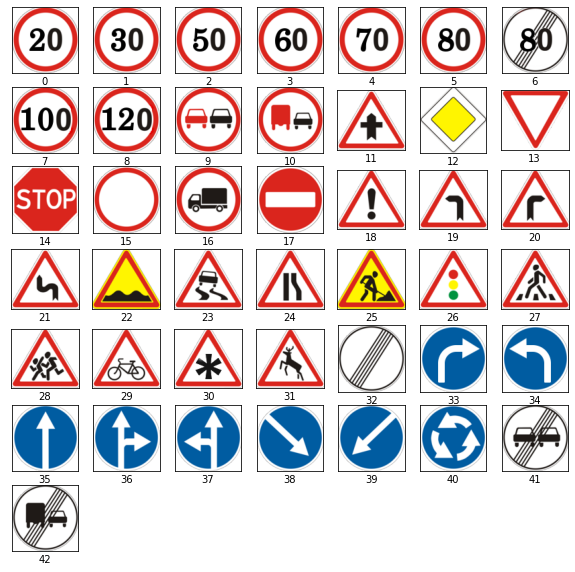

In [2]:
dir = 'datasets/traffic_signs'
    
plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = dir + "/meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

The following code loads the dataset from disk into memory. In addition, the 3 color values of each image (red, green blue) are scaled to 0..1. The shape of each image is 50 x 50 with 3 color values. The classification data is represented with one-hot encoding.

In [3]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [4]:
train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)


(50, 50, 3)


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (31367, 50, 50, 3)
X_valid.shape (7842, 50, 50, 3)
y_train.shape (31367, 43)
y_valid.shape (7842, 43)


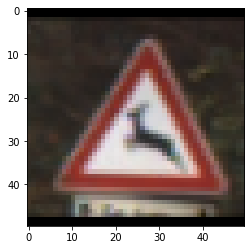

In [6]:
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

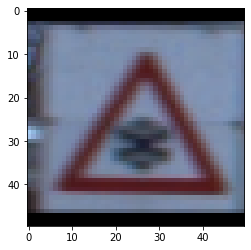

In [8]:
plt.imshow(cv2.cvtColor(X_train[30000], cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
y_train[30000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Part 1: Model Structure

The following code shows the configuration and training of a straightforward 3-layer model. You can reuse this code block throughout the assignment and simply change the various aspects under consideration.

**NOTE:** It is important that you clear the session whenever you train a different model to be able to compare them. Otherwise, Keras will continue training the model it has been working on, which might lead to confusing results.

Since training can take some time, we initially train with just a small number of epochs. You can adjust this variable as you like. Larger values will require more processing time. In Part 5, we will take our model and train for a long time. 

In [1]:
# For this project I will repaste the model in each section for clarity

In [18]:
epochs = 5
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(50, activation="sigmoid"),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
981/981 [==============================] - 5s 5ms/step - loss: 3.3648 - accuracy: 0.1635 - val_loss: 3.1572 - val_accuracy: 0.2553
Epoch 2/5
981/981 [==============================] - 5s 5ms/step - loss: 2.9879 - accuracy: 0.3072 - val_loss: 2.8463 - val_accuracy: 0.3358
Epoch 3/5
981/981 [==============================] - 5s 5ms/step - loss: 2.7060 - accuracy: 0.3759 - val_loss: 2.5984 - val_accuracy: 0.4040
Epoch 4/5
981/981 [==============================] - 5s 5ms/step - loss: 2.4806 - accuracy: 0.4266 - val_loss: 2.3960 - val_accuracy: 0.4393
Epoch 5/5
981/981 [==============================] - 5s 5ms/step - loss: 2.2938 - accuracy: 0.4645 - val_loss: 2.2228 - val_accuracy: 0.4726


Change model to have more layers.

In [22]:
# More epochs are needed to train models with more parameters
epochs = 20
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(50, activation="sigmoid"),
    keras.layers.Dense(50, activation="sigmoid"),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
981/981 [==============================] - 5s 5ms/step - loss: 3.5265 - accuracy: 0.0813 - val_loss: 3.4597 - val_accuracy: 0.0963
Epoch 2/20
981/981 [==============================] - 5s 5ms/step - loss: 3.4393 - accuracy: 0.1307 - val_loss: 3.4230 - val_accuracy: 0.1534
Epoch 3/20
981/981 [==============================] - 5s 5ms/step - loss: 3.4003 - accuracy: 0.1694 - val_loss: 3.3793 - val_accuracy: 0.1855
Epoch 4/20
981/981 [==============================] - 5s 5ms/step - loss: 3.3473 - accuracy: 0.1804 - val_loss: 3.3169 - val_accuracy: 0.2122
Epoch 5/20
981/981 [==============================] - 5s 5ms/step - loss: 3.2713 - accuracy: 0.1986 - val_loss: 3.2267 - val_accuracy: 0.1991
Epoch 6/20
981/981 [==============================] - 5s 5ms/step - loss: 3.1685 - accuracy: 0.2118 - val_loss: 3.1121 - val_accuracy: 0.2251
Epoch 7/20
981/981 [==============================] - 5s 5ms/step - loss: 3.0442 - accuracy: 0.2359 - val_loss: 2.9818 - val_accuracy: 0.2544
Epoch 

Change your model to have a wider layer.

In [25]:
epochs = 20
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# Added more nodes in form of a pyramid structure
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(150, activation="sigmoid"),
    keras.layers.Dense(75, activation="sigmoid"),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
981/981 [==============================] - 7s 7ms/step - loss: 3.4976 - accuracy: 0.0833 - val_loss: 3.4362 - val_accuracy: 0.1118
Epoch 2/20
981/981 [==============================] - 7s 7ms/step - loss: 3.4026 - accuracy: 0.1360 - val_loss: 3.3725 - val_accuracy: 0.1693
Epoch 3/20
981/981 [==============================] - 6s 6ms/step - loss: 3.3287 - accuracy: 0.1810 - val_loss: 3.2840 - val_accuracy: 0.1809
Epoch 4/20
981/981 [==============================] - 6s 7ms/step - loss: 3.2191 - accuracy: 0.2052 - val_loss: 3.1565 - val_accuracy: 0.2270
Epoch 5/20
981/981 [==============================] - 6s 6ms/step - loss: 3.0720 - accuracy: 0.2368 - val_loss: 2.9941 - val_accuracy: 0.2461
Epoch 6/20
981/981 [==============================] - 6s 7ms/step - loss: 2.9052 - accuracy: 0.2681 - val_loss: 2.8277 - val_accuracy: 0.2837
Epoch 7/20
981/981 [==============================] - 6s 7ms/step - loss: 2.7389 - accuracy: 0.3025 - val_loss: 2.6680 - val_accuracy: 0.3111
Epoch 

## Part 2: Activation Function

Using the model you selected in Part 1, try out three different activation functions (in addition to the sigmoid function that you already tried in Part 1). The Keras documentation lists the available activation functions: https://keras.io/api/layers/activations/ Please make sure to use activation functions that are appropriate for each layer. I.e., the softmax activation function for the final layer needs to remain unchanged and softmax should not be used inside the network.

In [26]:
epochs = 20
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(150, activation="elu"),
    keras.layers.Dense(75, activation="elu"),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
981/981 [==============================] - 7s 7ms/step - loss: 2.1802 - accuracy: 0.4521 - val_loss: 1.8946 - val_accuracy: 0.4788
Epoch 2/20
981/981 [==============================] - 7s 7ms/step - loss: 1.1526 - accuracy: 0.7040 - val_loss: 1.3030 - val_accuracy: 0.6307
Epoch 3/20
981/981 [==============================] - 6s 7ms/step - loss: 0.7924 - accuracy: 0.8026 - val_loss: 0.7719 - val_accuracy: 0.7964
Epoch 4/20
981/981 [==============================] - 7s 7ms/step - loss: 0.6090 - accuracy: 0.8484 - val_loss: 0.5028 - val_accuracy: 0.8850
Epoch 5/20
981/981 [==============================] - 7s 7ms/step - loss: 0.5052 - accuracy: 0.8753 - val_loss: 0.6979 - val_accuracy: 0.8124
Epoch 6/20
981/981 [==============================] - 7s 7ms/step - loss: 0.4414 - accuracy: 0.8927 - val_loss: 0.4765 - val_accuracy: 0.8764
Epoch 7/20
981/981 [==============================] - 6s 7ms/step - loss: 0.3850 - accuracy: 0.9052 - val_loss: 0.4335 - val_accuracy: 0.8889
Epoch 

In [27]:
epochs = 20
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# ReLU is a commonly used activation function
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(150, activation="relu"),
    keras.layers.Dense(75, activation="relu"),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
981/981 [==============================] - 6s 7ms/step - loss: 2.4733 - accuracy: 0.3887 - val_loss: 2.3422 - val_accuracy: 0.3574
Epoch 2/20
981/981 [==============================] - 6s 6ms/step - loss: 1.3694 - accuracy: 0.6502 - val_loss: 1.4134 - val_accuracy: 0.6027
Epoch 3/20
981/981 [==============================] - 6s 7ms/step - loss: 0.9400 - accuracy: 0.7619 - val_loss: 0.9710 - val_accuracy: 0.7229
Epoch 4/20
981/981 [==============================] - 7s 7ms/step - loss: 0.7185 - accuracy: 0.8182 - val_loss: 0.5965 - val_accuracy: 0.8625
Epoch 5/20
981/981 [==============================] - 6s 7ms/step - loss: 0.5914 - accuracy: 0.8535 - val_loss: 0.6470 - val_accuracy: 0.8319
Epoch 6/20
981/981 [==============================] - 6s 7ms/step - loss: 0.5091 - accuracy: 0.8741 - val_loss: 0.5281 - val_accuracy: 0.8665
Epoch 7/20
981/981 [==============================] - 6s 7ms/step - loss: 0.4424 - accuracy: 0.8917 - val_loss: 0.5732 - val_accuracy: 0.8460
Epoch 

In [28]:
epochs = 20
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# SELU requires LeCun normalization
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(150, activation="selu",kernel_initializer='lecun_normal'),
    keras.layers.Dense(75, activation="selu",kernel_initializer='lecun_normal'),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
981/981 [==============================] - 7s 7ms/step - loss: 1.9653 - accuracy: 0.5009 - val_loss: 1.4443 - val_accuracy: 0.6052
Epoch 2/20
981/981 [==============================] - 6s 7ms/step - loss: 0.9555 - accuracy: 0.7623 - val_loss: 1.3258 - val_accuracy: 0.6278
Epoch 3/20
981/981 [==============================] - 6s 6ms/step - loss: 0.6392 - accuracy: 0.8421 - val_loss: 0.5852 - val_accuracy: 0.8535
Epoch 4/20
981/981 [==============================] - 7s 7ms/step - loss: 0.4905 - accuracy: 0.8773 - val_loss: 0.4253 - val_accuracy: 0.9040
Epoch 5/20
981/981 [==============================] - 6s 6ms/step - loss: 0.4049 - accuracy: 0.8997 - val_loss: 0.4771 - val_accuracy: 0.8752
Epoch 6/20
981/981 [==============================] - 6s 6ms/step - loss: 0.3453 - accuracy: 0.9146 - val_loss: 0.4027 - val_accuracy: 0.8903
Epoch 7/20
981/981 [==============================] - 6s 6ms/step - loss: 0.2983 - accuracy: 0.9277 - val_loss: 0.3179 - val_accuracy: 0.9206
Epoch 

Based on these results, which activation function do you choose to continue with?

Answer: I will use the SELU activation function as it produced the highest validation accuracy.

## Part 3: Batch Normalization

Add Batch Normalization to the model you chose in Part 2. Depending on your activation function, add the appropriate initialization.

In [29]:

epochs = 20
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# In this model, batch normalization is applied after every layer
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(150, activation="selu",kernel_initializer='lecun_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(75, activation="selu",kernel_initializer='lecun_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
981/981 [==============================] - 12s 12ms/step - loss: 1.4231 - accuracy: 0.6453 - val_loss: 1.7167 - val_accuracy: 0.6004
Epoch 2/20
981/981 [==============================] - 11s 12ms/step - loss: 0.7277 - accuracy: 0.8220 - val_loss: 0.9345 - val_accuracy: 0.7410
Epoch 3/20
981/981 [==============================] - 11s 12ms/step - loss: 0.5355 - accuracy: 0.8674 - val_loss: 0.5088 - val_accuracy: 0.8576
Epoch 4/20
981/981 [==============================] - 11s 12ms/step - loss: 0.4461 - accuracy: 0.8875 - val_loss: 0.6129 - val_accuracy: 0.8236
Epoch 5/20
981/981 [==============================] - 11s 12ms/step - loss: 0.3837 - accuracy: 0.9020 - val_loss: 1.0735 - val_accuracy: 0.7521
Epoch 6/20
981/981 [==============================] - 11s 12ms/step - loss: 0.3409 - accuracy: 0.9140 - val_loss: 0.3545 - val_accuracy: 0.9013
Epoch 7/20
981/981 [==============================] - 11s 12ms/step - loss: 0.3081 - accuracy: 0.9211 - val_loss: 0.6443 - val_accuracy:

## Part 4: Regularization

Apply two regularization techniques to your model.

In [30]:

epochs = 20
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# Small value for L1
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(150, activation="selu",kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1(0.0001)),
    keras.layers.Dense(75, activation="selu",kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1(0.0001)),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
981/981 [==============================] - 9s 9ms/step - loss: 3.0852 - accuracy: 0.4988 - val_loss: 2.5168 - val_accuracy: 0.6089
Epoch 2/20
981/981 [==============================] - 9s 9ms/step - loss: 2.0357 - accuracy: 0.7545 - val_loss: 2.3341 - val_accuracy: 0.6261
Epoch 3/20
981/981 [==============================] - 9s 9ms/step - loss: 1.6697 - accuracy: 0.8330 - val_loss: 1.5785 - val_accuracy: 0.8448
Epoch 4/20
981/981 [==============================] - 9s 9ms/step - loss: 1.4684 - accuracy: 0.8645 - val_loss: 1.3574 - val_accuracy: 0.8940
Epoch 5/20
981/981 [==============================] - 9s 9ms/step - loss: 1.3297 - accuracy: 0.8843 - val_loss: 1.4248 - val_accuracy: 0.8392
Epoch 6/20
981/981 [==============================] - 9s 9ms/step - loss: 1.2219 - accuracy: 0.8981 - val_loss: 1.2665 - val_accuracy: 0.8695
Epoch 7/20
981/981 [==============================] - 9s 9ms/step - loss: 1.1316 - accuracy: 0.9083 - val_loss: 1.1213 - val_accuracy: 0.9028
Epoch 

In [34]:
epochs = 20
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# Very small value for L2
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(150, activation="selu",kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.000001)),
    keras.layers.Dense(75, activation="selu",kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l2(0.000001)),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/20
981/981 [==============================] - 9s 9ms/step - loss: 1.9646 - accuracy: 0.5015 - val_loss: 1.4220 - val_accuracy: 0.6132
Epoch 2/20
981/981 [==============================] - 8s 8ms/step - loss: 0.9556 - accuracy: 0.7620 - val_loss: 1.2809 - val_accuracy: 0.6376
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.6400 - accuracy: 0.8426 - val_loss: 0.5853 - val_accuracy: 0.8532
Epoch 4/20
981/981 [==============================] - 9s 9ms/step - loss: 0.4908 - accuracy: 0.8774 - val_loss: 0.4253 - val_accuracy: 0.9032
Epoch 5/20
981/981 [==============================] - 10s 10ms/step - loss: 0.4059 - accuracy: 0.8996 - val_loss: 0.4317 - val_accuracy: 0.8870
Epoch 6/20
981/981 [==============================] - 9s 9ms/step - loss: 0.3457 - accuracy: 0.9141 - val_loss: 0.4088 - val_accuracy: 0.8859
Epoch 7/20
981/981 [==============================] - 9s 9ms/step - loss: 0.2986 - accuracy: 0.9272 - val_loss: 0.3196 - val_accuracy: 0.9198
Epoc

Does batch regularization improve the validation accuracy for your model?

Answer: ___L1 regularization had a minor negative impact on model performance. L2 was able to surpass the highest score of prior models in epoch 18.______

## Part 5: Longer Training

Pick one of the models you have constructed above. Select the one that you think will be most accurate for the test data.

Increase the training to run over a large number of epochs (30 or more). Feel free to change the optimizer and learning rate for this part if you like (not required for this project). Plot the accuracy and validation accuray (and loss if you like).

In [41]:
# There is a chance that running the L2 regularized model with a smaller regularization value for a longer period of time will improve performance.
epochs = 35
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# I found that using different regularizaion strengths on hidden layers improved performance 
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),
    keras.layers.Dense(150, activation="selu",kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.000001)),
    keras.layers.Dense(75, activation="selu",kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dense(43, activation="softmax")
])

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.h5")

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid),callbacks=[checkpoint_cb])

Epoch 1/35
981/981 [==============================] - 8s 8ms/step - loss: 1.6363 - accuracy: 0.5500 - val_loss: 0.8736 - val_accuracy: 0.7369
Epoch 2/35
981/981 [==============================] - 7s 7ms/step - loss: 0.6757 - accuracy: 0.8024 - val_loss: 0.6465 - val_accuracy: 0.8201
Epoch 3/35
981/981 [==============================] - 7s 8ms/step - loss: 0.4820 - accuracy: 0.8618 - val_loss: 0.5298 - val_accuracy: 0.8495
Epoch 4/35
981/981 [==============================] - 8s 8ms/step - loss: 0.4082 - accuracy: 0.8832 - val_loss: 0.3455 - val_accuracy: 0.8993
Epoch 5/35
981/981 [==============================] - 7s 8ms/step - loss: 0.3543 - accuracy: 0.8997 - val_loss: 0.2729 - val_accuracy: 0.9285
Epoch 6/35
981/981 [==============================] - 8s 8ms/step - loss: 0.3012 - accuracy: 0.9154 - val_loss: 0.5056 - val_accuracy: 0.8702
Epoch 7/35
981/981 [==============================] - 7s 7ms/step - loss: 0.2974 - accuracy: 0.9158 - val_loss: 0.2565 - val_accuracy: 0.9314
Epoch 

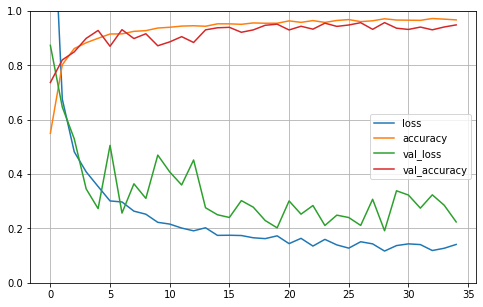

In [42]:
# Displays loss, accuracy, val_loss, and val_accuracy after seach epoch 
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Part 6: Evaluation

Evaluate the model you have trained in Part 5 on the test data.

In [43]:
model.evaluate(test_images, test_labels)

395/395 [==============================] - 1s 2ms/step - loss: 1.4410 - accuracy: 0.8185


[1.4410219192504883, 0.818527340888977]

In [44]:
model.summary() # Prints model details

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7500)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               1125150   
_________________________________________________________________
dense_1 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_2 (Dense)              (None, 43)                3268      
Total params: 1,139,743
Trainable params: 1,139,743
Non-trainable params: 0
_________________________________________________________________


What is the final accuracy of your model?

Answer: ___Final accuracy is 0.8185______

Please summarize the characteristics of your model:

- Number of layers: 1 input, 2 hidden, 1 output
- Number of nodes per layer: 7501, 151, 76, 43 respetively
- Initialization: LeCun Normal
- Activation Function: SELU
- Normalization: None
- Regularization: L2 with value 0.000001 and 0.0001
- Optimizer: Adam

In the following table, summarize the validation accuracy and running time during training for the different steps you have taken in the project. For parts, where you tried different models/parameters, report the one that you continued to use in later parts.

| Model                                 | validation accuracy | running time (per step) |
| ------------------------------------- | ------------------- |------------------------ |
| Baseline model in Part 1 (50/43)      | 47.26 %             |   5 ms                  |
| Your model in Part 1 (...)            | 59.33 %             |   6 ms                  |
| Activation function in Part 2         | 95.31 %             |   6 ms                  |
| Batch normalization in Part 3         | 79.83 %             |  12 ms                  |
| Regularization in Part 4              | 95.73 %             |   7 ms                  |



Reflection: During this project, what worked as expected? Was there anything that surprised you? What did you learn?
    
Answer: __ Regularization worked as expected and improved the performance on the validation sets. Though I am surprised that I needed to use a small value to have good results. I am surprised that SELU worked so well and reached 90%+ validation performance in only 7 epochs -- faster than all other activation functions. I also learned that SELU was a good choice for this type of problem, I had not used or heard of it prior to this project. I am surprised that there is a drastic drop in performance from the validation set to the test set. Maybe a larger validation set should be used in the future. I am surprised that an extra 15 epochs and L2 regularization only resulted in a .42% increase in performance. _______